# Bootstrap analysis of all task's subtypes

In [55]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
from scipy import cluster as scl
from scipy import stats, integrate
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import itertools
from nilearn import plotting as nlp

In [32]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [69]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [96]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

In [97]:
colors_list = ["#e37f7d",
        "#55c75c",
        "#8f46b7",
        "#87bb37",
        "#5b63d5",
        "#b1b23a",
        "#bb75e7",
        "#4c9333",
        "#c5379e",
        "#50c282",
        "#e36fcf",
        "#357642",
        "#e44586",
        "#64c9ac",
        "#cf3b4a",
        "#3abec8",
        "#d8552f",
        "#5e86e3",
        "#de8930",
        "#5d5da1",
        "#cea53f",
        "#9d4994",
        "#9db26a",
        "#b43a6a",
        "#489a76",
        "#c486c9",
        "#667328",
        "#9c95dc",
        "#8f6f2f",
        "#529fd2",
        "#a2532a",
        "#e084ac",
        "#da9668",
        "#954f74",
        "#a55155"]

In [98]:
def clusters_color(n_sbt,color = None):
    # initiate color list
    if color == None:
        color = colors_list[:n_sbt]
    elif color!= n_sbt:
        sys.exit("number of cluter doesn't match the color list")
    # creat linear segemented colors
    lin = LinearSegmentedColormap.from_list(name='s{}'.format(str(n_sbt)),
                                             colors = color,
                                             N=n_sbt)
    return lin,color   

In [35]:
#  Set path
path_root = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno'
mask_path = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/mask_roi_resample.nii.gz'

In [36]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtype_stack.csv'))

In [37]:
df_stack.head()

EMO_contrast_fear_vs_neut_sub1  EMO_contrast_fear_vs_neut_sub2  \
0                       -0.229590                        0.789998   
1                       -0.154963                        0.394645   
2                       -0.059922                        0.525727   
3                       -0.295939                        0.381127   
4                       -0.288014                        0.364902   

   EMO_contrast_fear_vs_neut_sub3  EMO_contrast_fear_vs_neut_sub4  \
0                        0.256789                        0.657664   
1                        0.336540                        0.633725   
2                        0.295237                        0.140892   
3                        0.431556                        0.458956   
4                        0.416104                        0.425780   

   EMO_contrast_fear_vs_neut_sub5  GAM_contrast_win_vs_loss_sub1  \
0                       -0.688034                      -0.280607   
1                       -0.606700                      -0.250487   
2                       -0.546841                      -0.230613   
3                       -0.489885                      -0.960959   
4                       -0.462302                      -0.976032   

   GAM_contrast_win_vs_loss_sub2  GAM_contrast_win_vs_loss_sub3  \
0                      -0.379255                       0.684838   
1                      -0.328870                       0.252394   
2                      -0.656313                       0.072737   
3                       0.475971                       0.144408   
4                       0.543835                       0.131646   

   GAM_contrast_win_vs_loss_sub4  GAM_contrast_win_vs_loss_sub5     ...       \
0                      -0.896567                       0.743033     ...        
1                      -0.846275                       0.917483     ...        
2                      -0.382268                       0.885286     ...        
3                      -0.881855                       0.977744     ...        
4                      -0.968926                       1.016922     ...        

   WM_0bk_sub1  WM_0bk_sub2  WM_0bk_sub3  WM_0bk_sub4  WM_0bk_sub5  \
0     1.112975     1.033061    -0.506427     0.362818    -0.921810   
1     1.080058     0.970486    -0.525101     0.382929    -0.822772   
2     0.993790     0.799496    -0.415839     0.303451    -0.765309   
3     0.441557     0.566373    -0.398126     0.347071    -0.367073   
4     0.490695     0.517005    -0.398157     0.346950    -0.342697   

   WM_2bk_sub1  WM_2bk_sub2  WM_2bk_sub3  WM_2bk_sub4  WM_2bk_sub5  
0     0.725796     0.279384    -0.077054     0.629170    -0.585860  
1     0.705165     0.320632    -0.014777     0.641639    -0.609268  
2     0.517658     0.301844     0.035949     0.472618    -0.471403  
3     0.421399     0.250358    -0.320497     0.466519    -0.338982  
4     0.400953     0.206851    -0.279168     0.471151    -0.338452  

[5 rows x 90 columns]

In [59]:
# create corelation matrix a distance matrix 
use_columns = df_stack.columns.get_values()
corr = np.corrcoef(df_stack.get_values().T)
dist = scl.hierarchy.distance.pdist(df_stack.T)

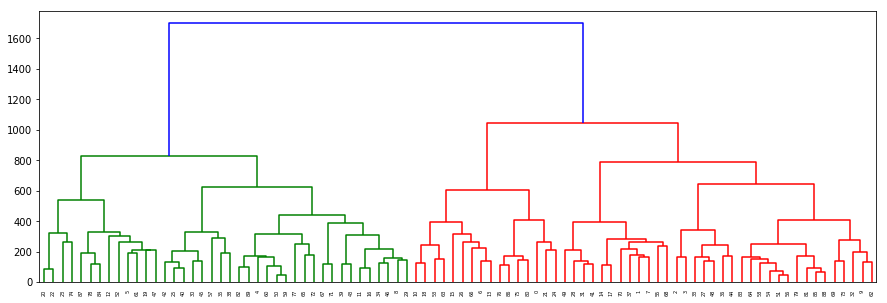

In [86]:
# Number of subtypes
n_sbt = 9
# hierachical clustering
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

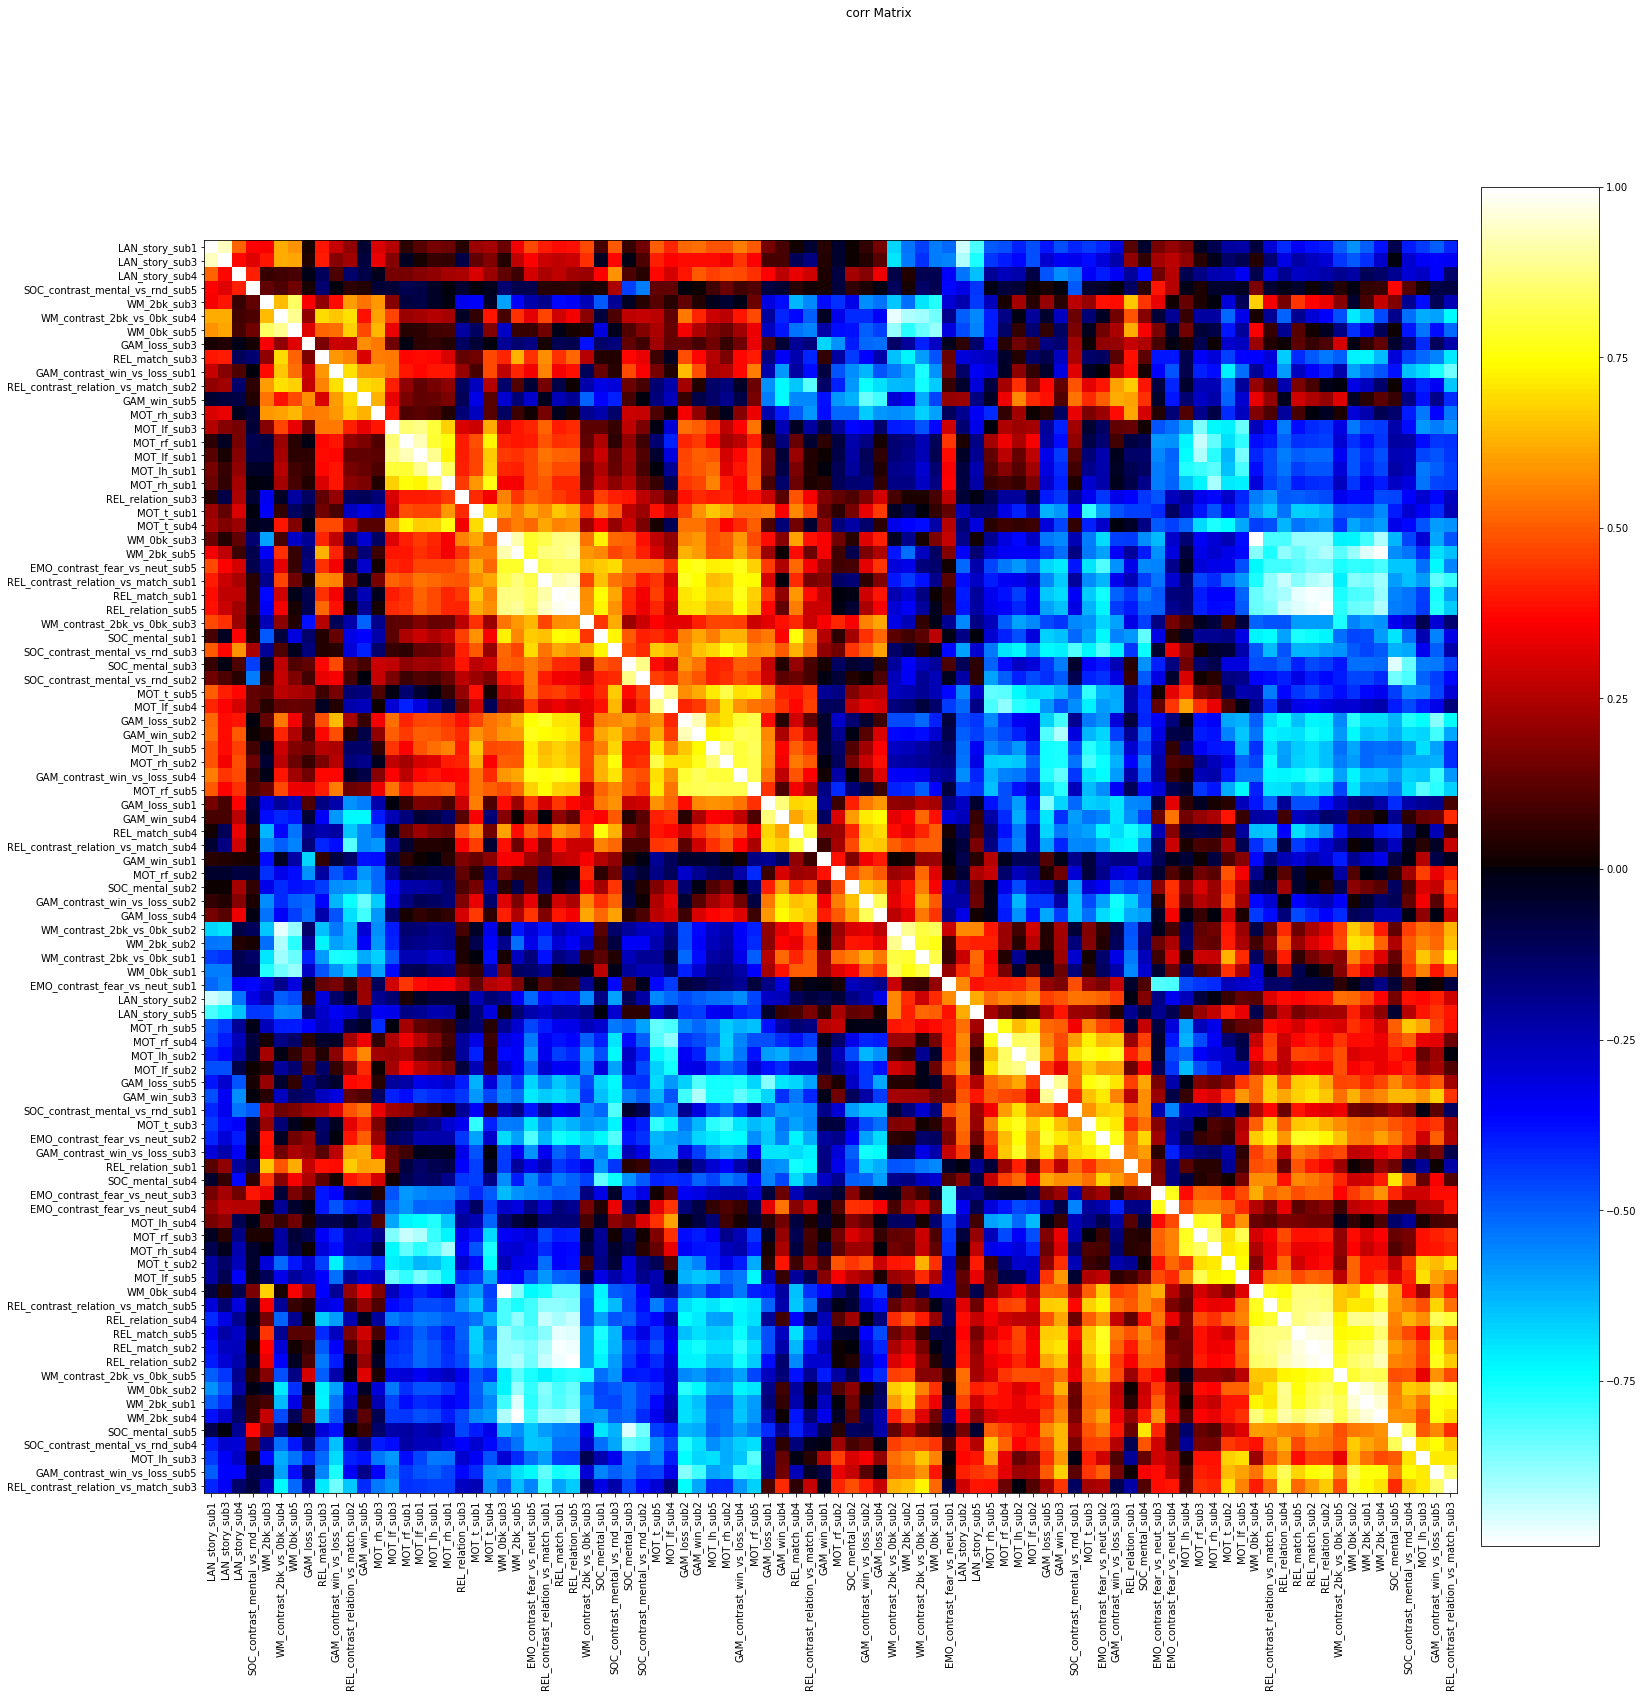

In [87]:
# Plot the RhoG matrix again, but now ordered by hierarchy
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(corr[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('corr Matrix')

## Calculate siliouhette

In [88]:
%%octave -o sil,hier,ind_s,val_s -i corr,n_sbt

hier = niak_hierarchical_clustering(corr,struct('flag_verbose',false)); # replication the hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',n_sbt)); # Cut the hierarchy to get clusters
sil = niak_build_avg_silhouette (corr,hier);
[val_s,ind_s] = niak_find_local_max_1d(2:80,sil(1:79))

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 Done ! 

val_s =

   0.51856

   0.20395

ind_s =

   2

   9

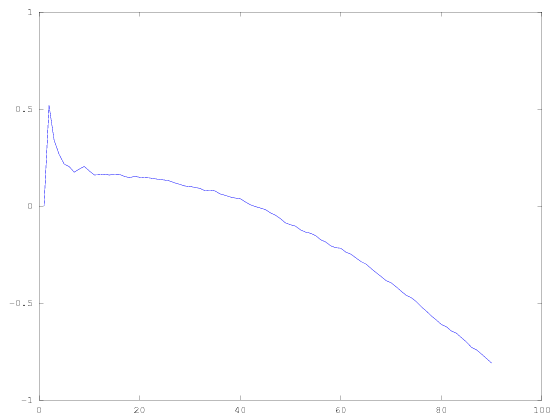

In [89]:
%octave plot(sil)

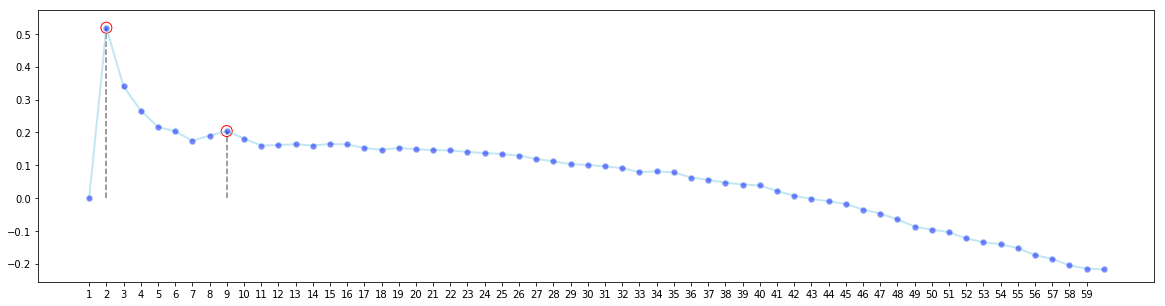

In [102]:
# plot silhouette figure
sil_trunc = sil[:60]
plt.figure(figsize=(20,5))
plt.plot(np.arange(1,len(sil_trunc)+1),sil_trunc, marker='o',
         markerfacecolor='blue',alpha = 0.5,
         markersize=6, color='skyblue', linewidth=2)
if isinstance(ind_s,np.ndarray):
    for ind, val in zip(ind_s,val_s):
        plt.scatter(int(ind),float(val), s=120, facecolors='none', edgecolors='r')
        plt.vlines(int(ind),0,float(val),linestyle='--',alpha = 0.5)
else:
    plt.scatter(int(ind_s),float(val_s), s=120, facecolors='none', edgecolors='r')
    plt.vlines(int(ind_s),0,float(val_s),linestyle='--',alpha = 0.5)
    
plt.xticks(np.arange(1,len(sil_trunc), step=1));
#plt.savefig(os.path.join(path_root,'Figures/phenotypes/silhouette.svg'))

In [91]:
# Order clustered correlation matrix
corr_clust = corr[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [92]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(corr_clust, cuts, 1)

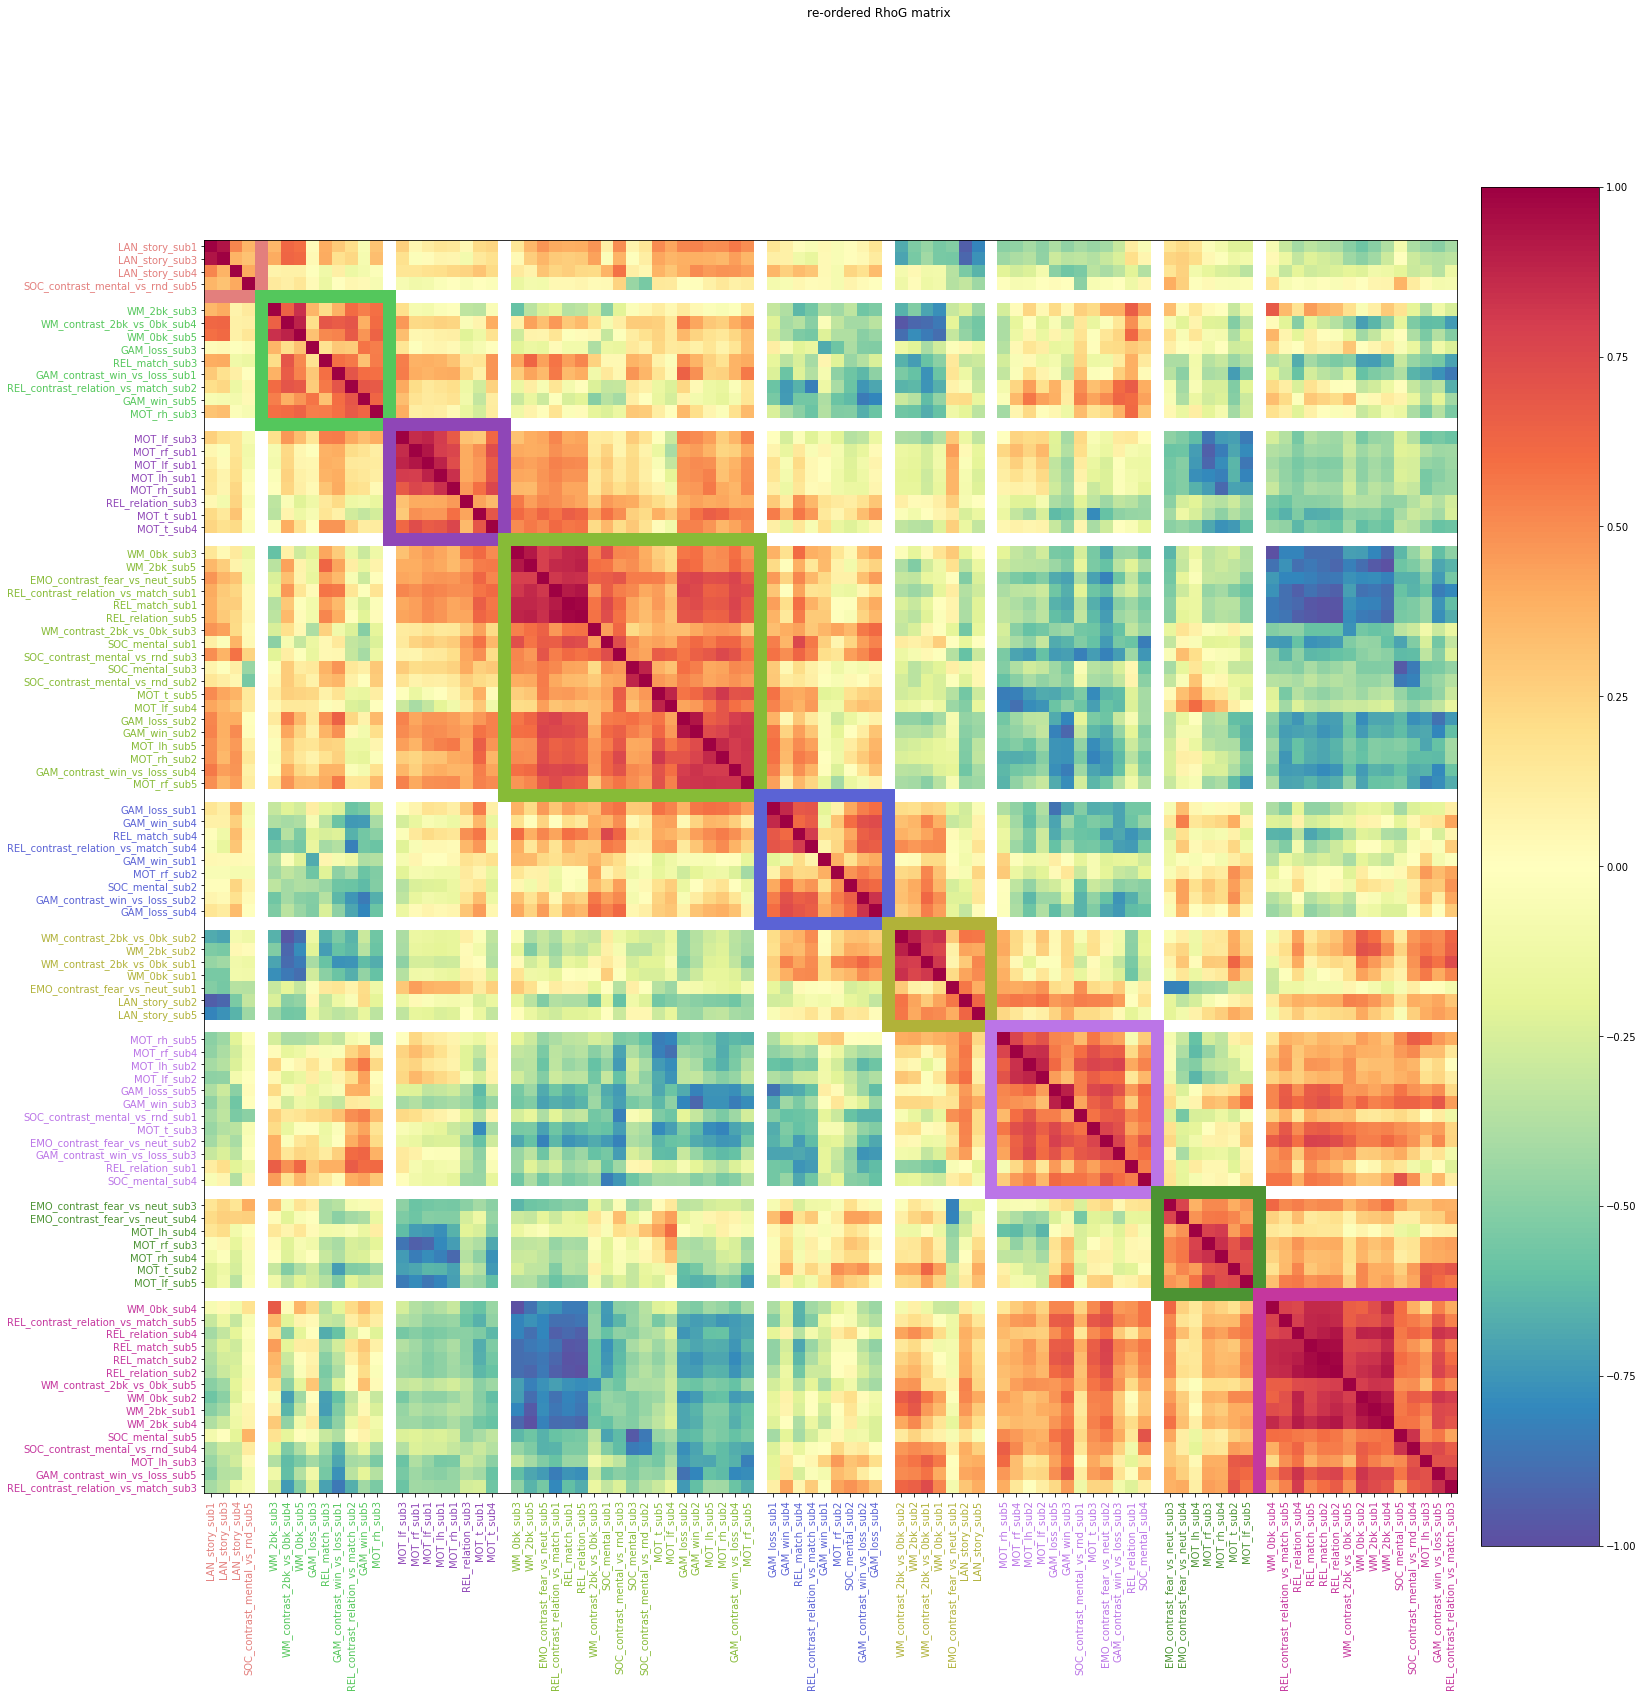

In [93]:
# Set figure
lin,color = clusters_color(n_sbt)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat, cmap=lin,interpolation='none')
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [color[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoG matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

In [94]:
# Here are the groups I found:
for sid in np.unique(part):
    match_cols = [use_columns[x] for x in np.where(part==sid)[0]]
    print('Subtype {} has the following variables:'.format(sid))
    for col in match_cols:
        print('    {}'.format(col))

Subtype 1 has the following variables:
    LAN_story_sub1
    LAN_story_sub3
    LAN_story_sub4
    SOC_contrast_mental_vs_rnd_sub5
Subtype 2 has the following variables:
    GAM_contrast_win_vs_loss_sub1
    GAM_loss_sub3
    GAM_win_sub5
    MOT_rh_sub3
    REL_match_sub3
    REL_contrast_relation_vs_match_sub2
    WM_contrast_2bk_vs_0bk_sub4
    WM_0bk_sub5
    WM_2bk_sub3
Subtype 3 has the following variables:
    MOT_rf_sub1
    MOT_lh_sub1
    MOT_t_sub1
    MOT_t_sub4
    MOT_lf_sub1
    MOT_lf_sub3
    MOT_rh_sub1
    REL_relation_sub3
Subtype 4 has the following variables:
    EMO_contrast_fear_vs_neut_sub5
    GAM_contrast_win_vs_loss_sub4
    GAM_loss_sub2
    GAM_win_sub2
    MOT_rf_sub5
    MOT_lh_sub5
    MOT_t_sub5
    MOT_lf_sub4
    MOT_rh_sub2
    REL_match_sub1
    REL_relation_sub5
    REL_contrast_relation_vs_match_sub1
    SOC_mental_sub1
    SOC_mental_sub3
    SOC_contrast_mental_vs_rnd_sub2
    SOC_contrast_mental_vs_rnd_sub3
    WM_contrast_2bk_vs_0bk_sub3
   

In [95]:
# Make a new cluster table with the average scores of these subtypes
data = np.array([np.mean(df_stack[[use_columns[x] for x in np.where(part==sid)[0]]],1) for sid in np.unique(part)])
ind = df_stack.index
col_names = ['Cluster_{}'.format(x) for x in np.unique(part)]
sbt_clusters = pd.DataFrame(data=data.T, columns=col_names, index=ind)

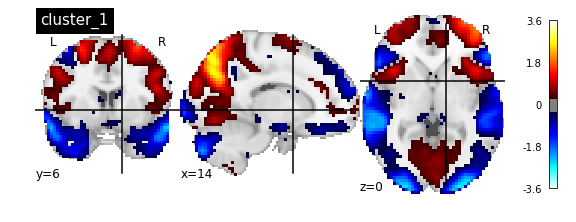

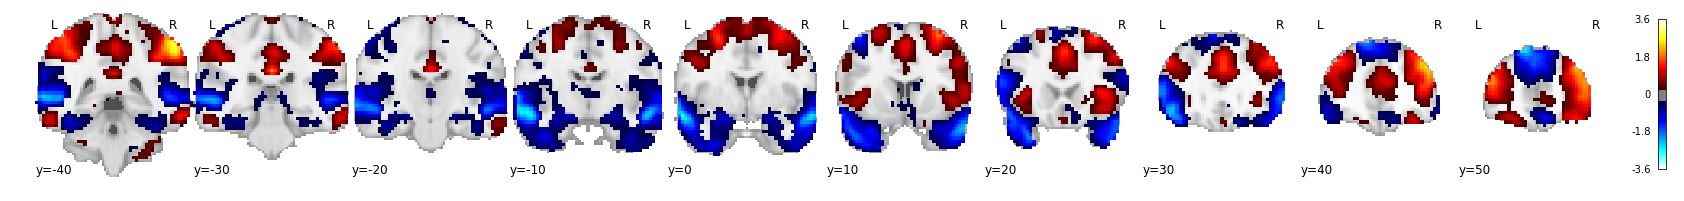

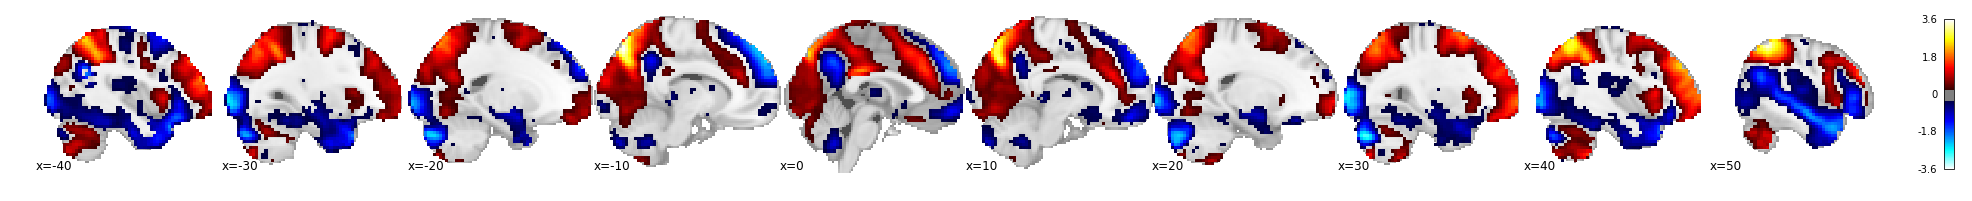

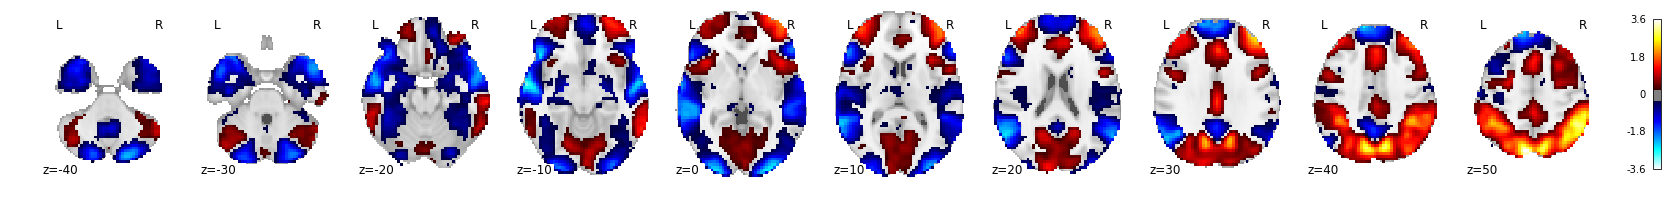

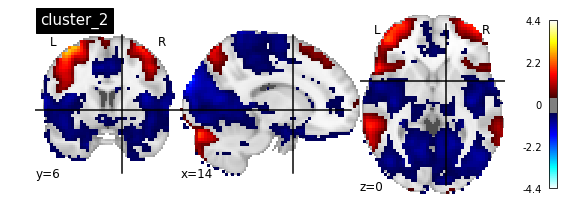

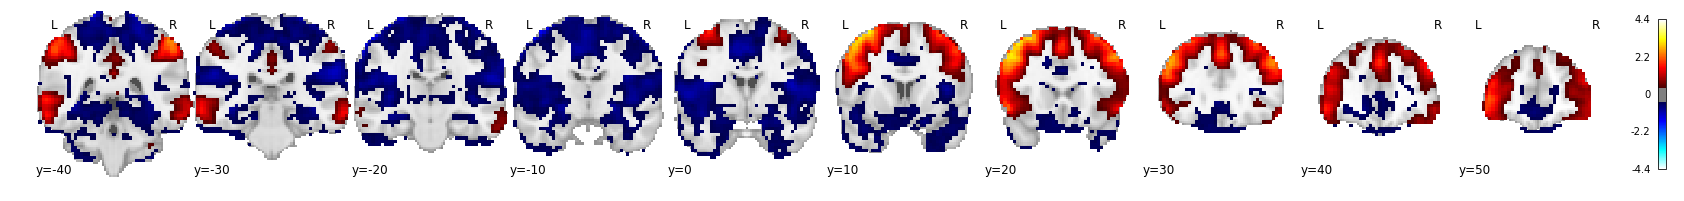

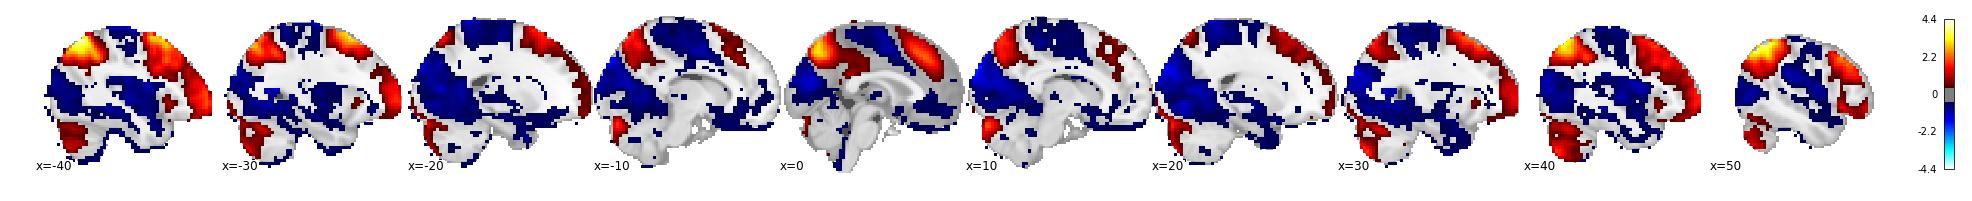

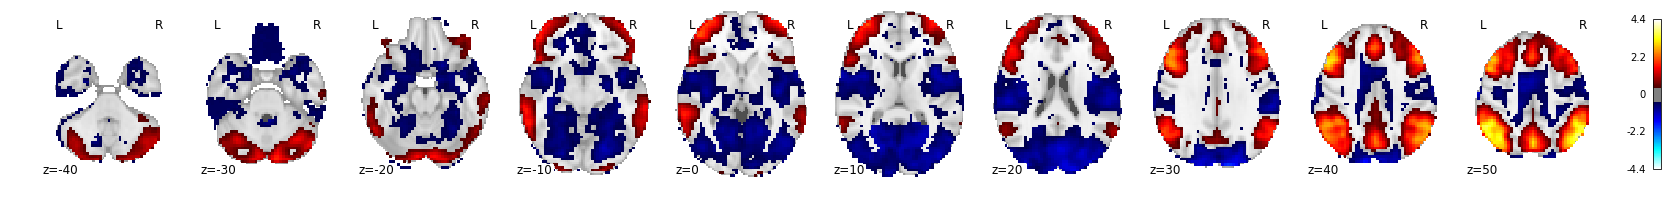

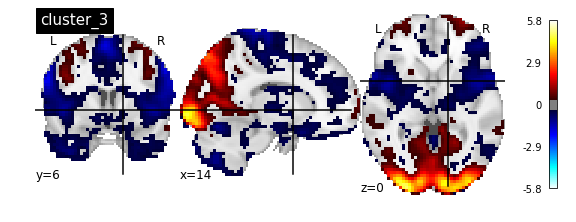

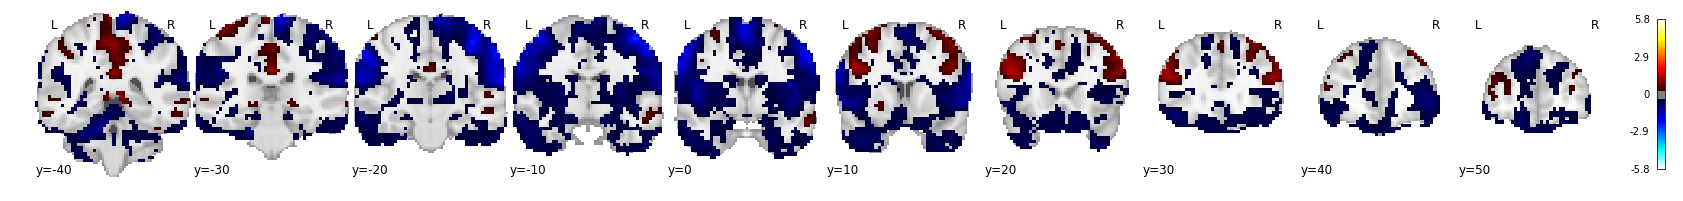

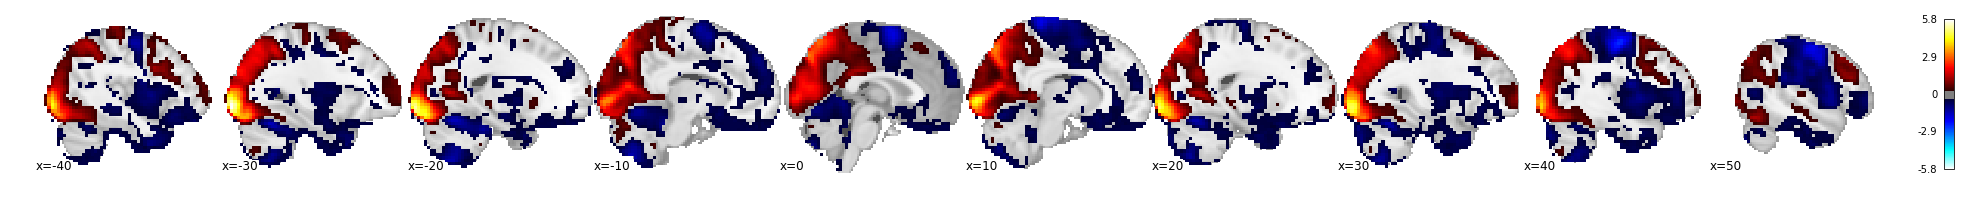

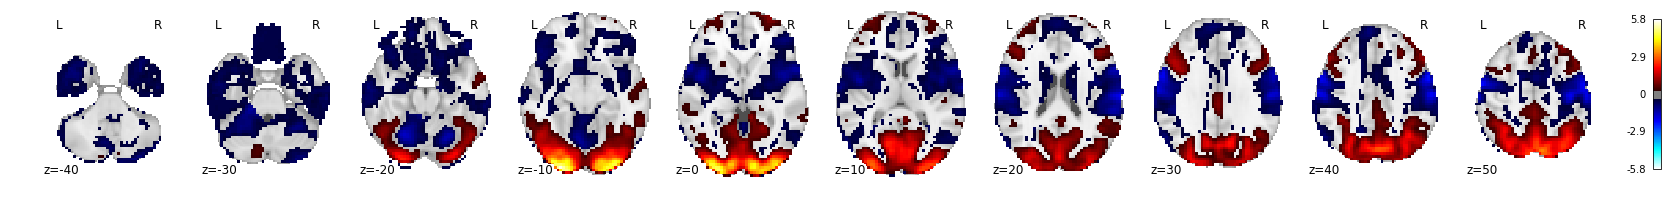

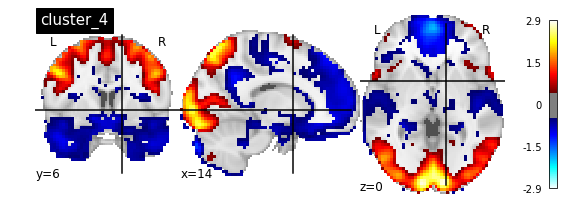

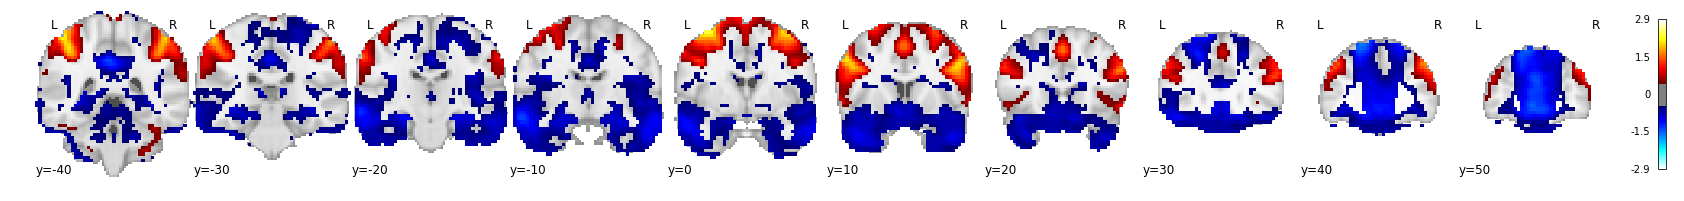

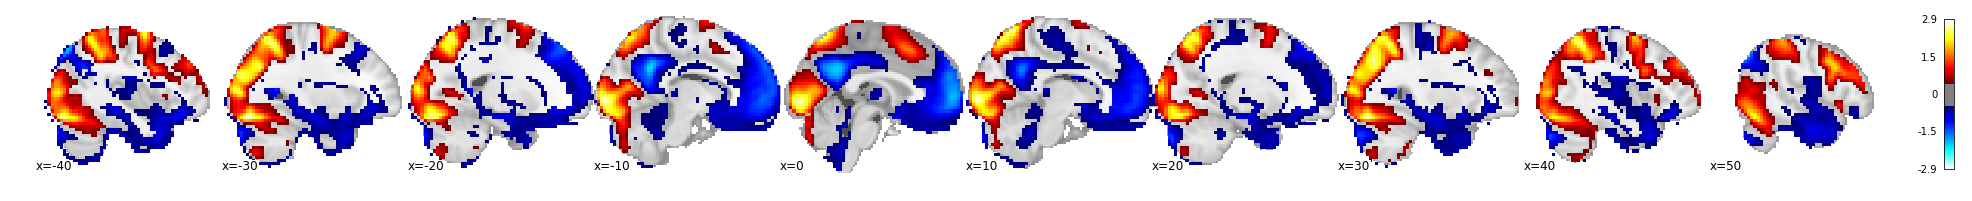

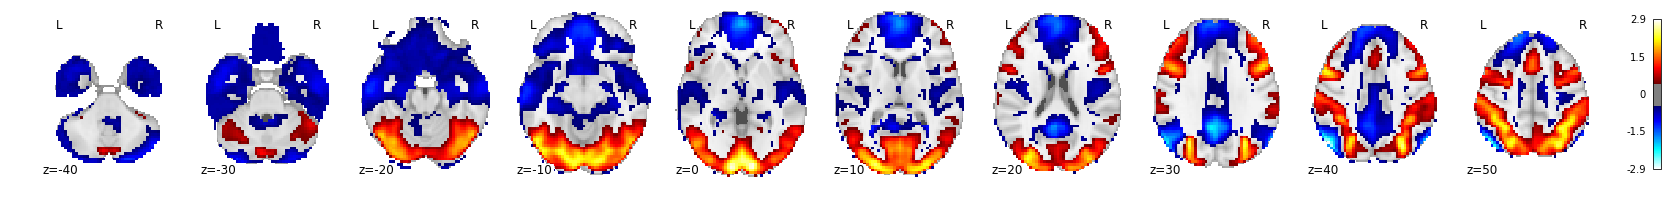

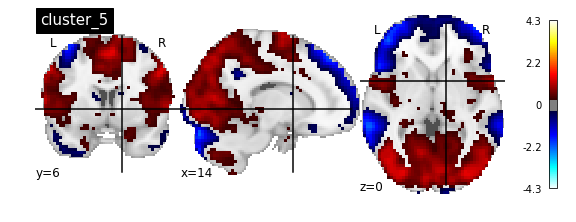

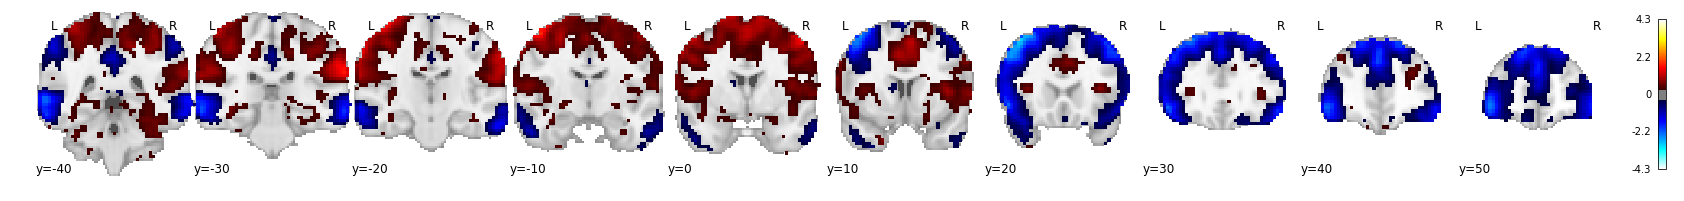

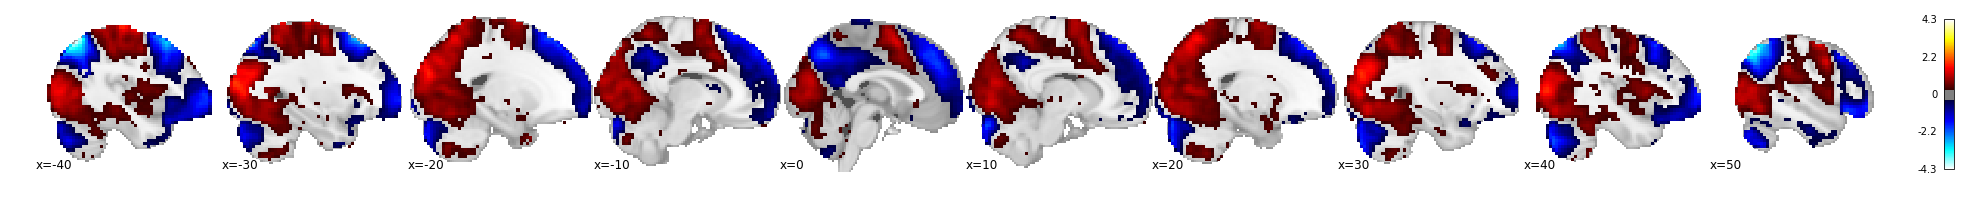

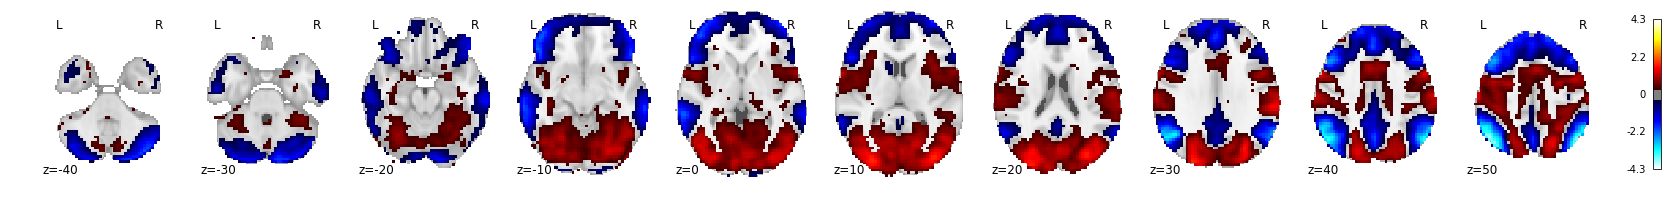

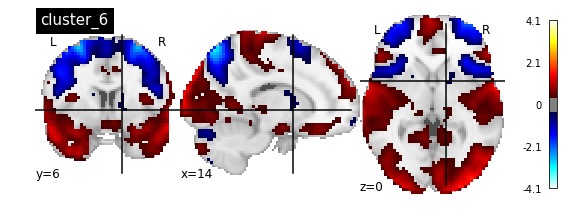

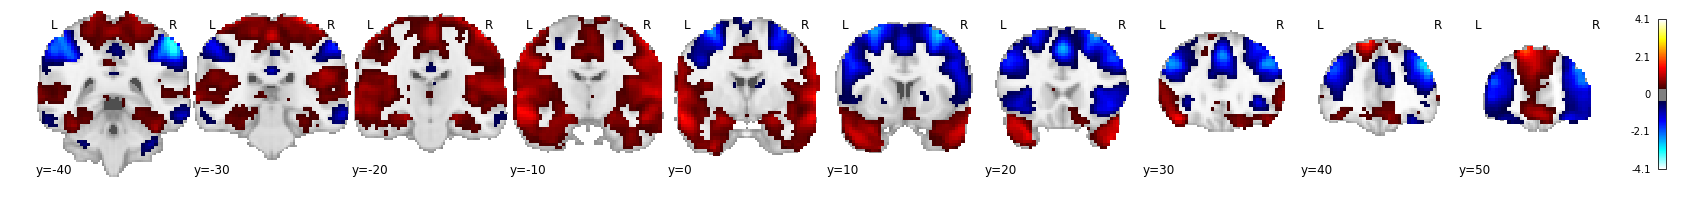

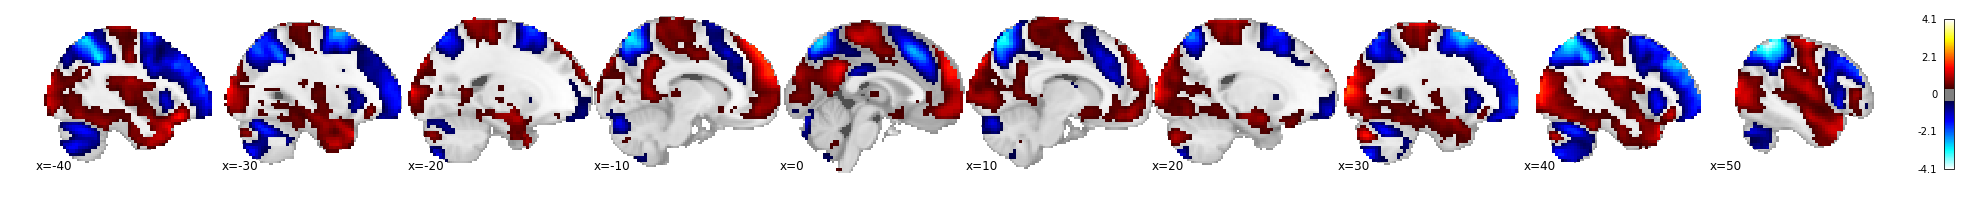

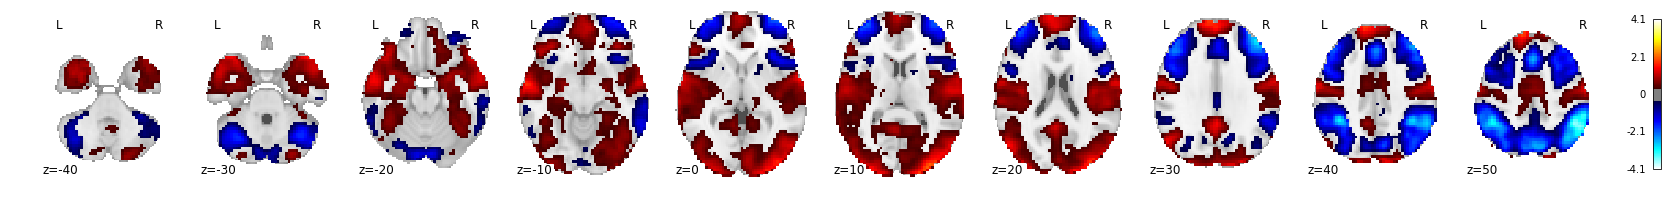

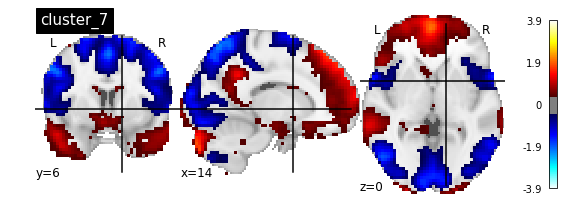

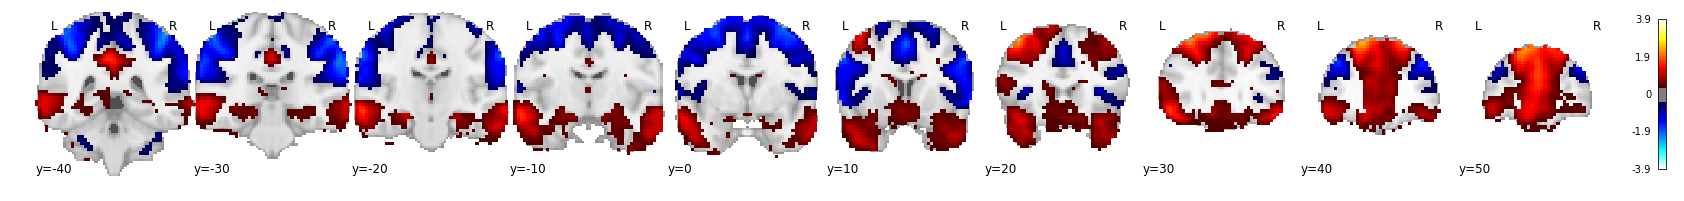

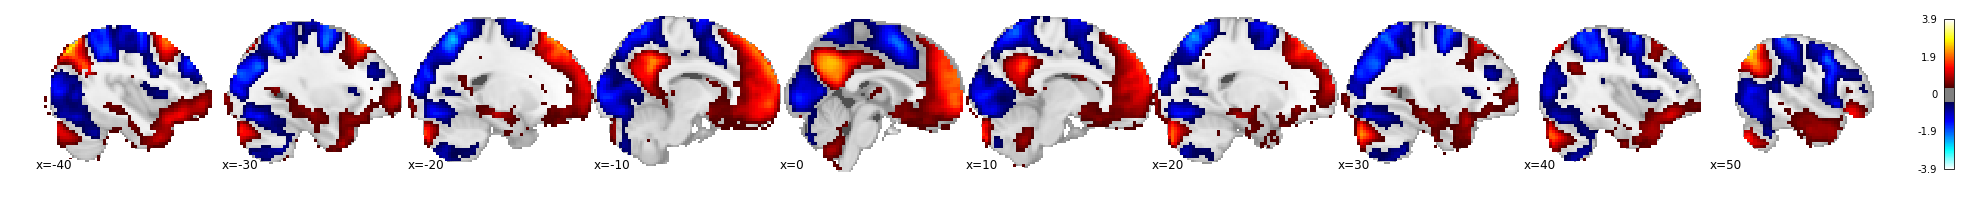

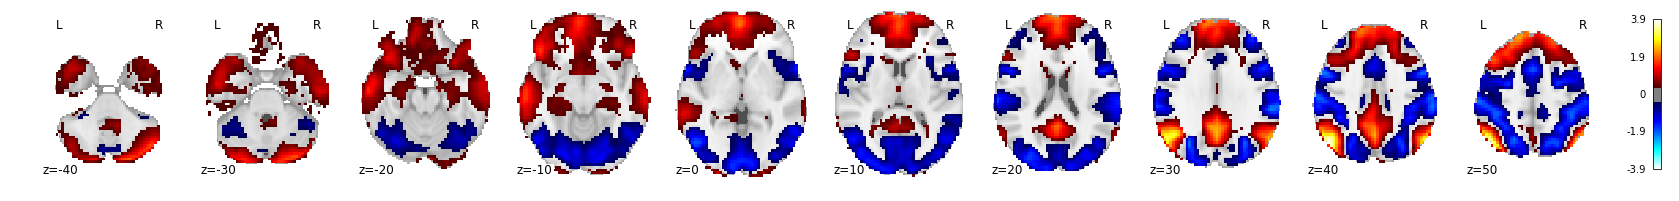

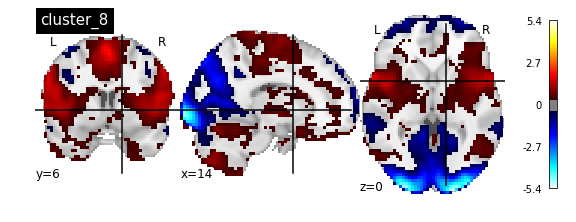

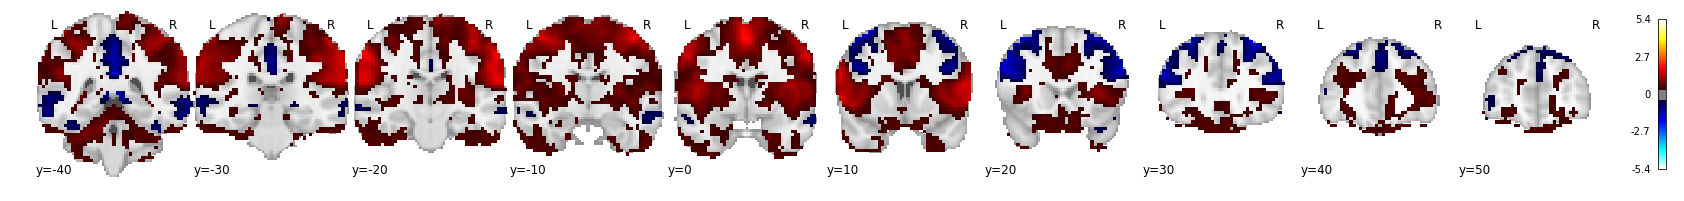

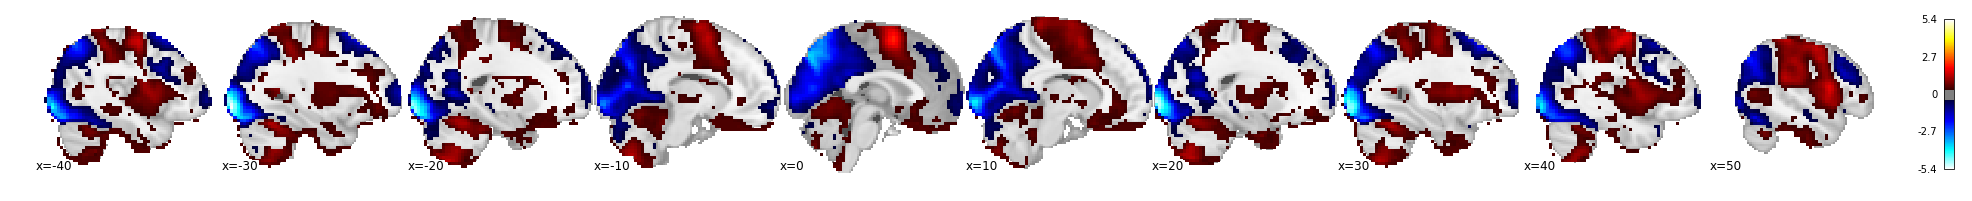

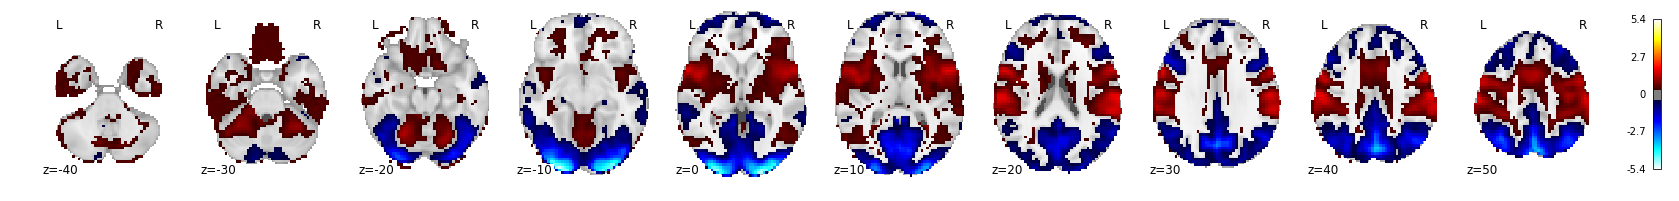

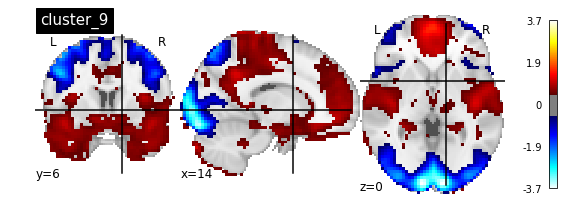

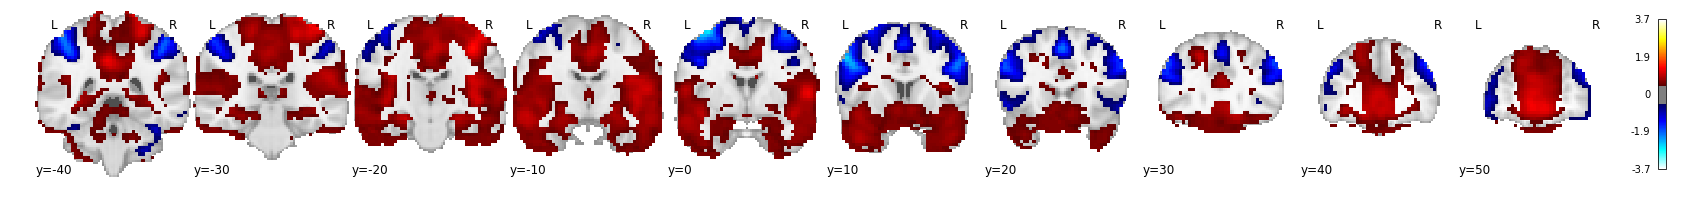

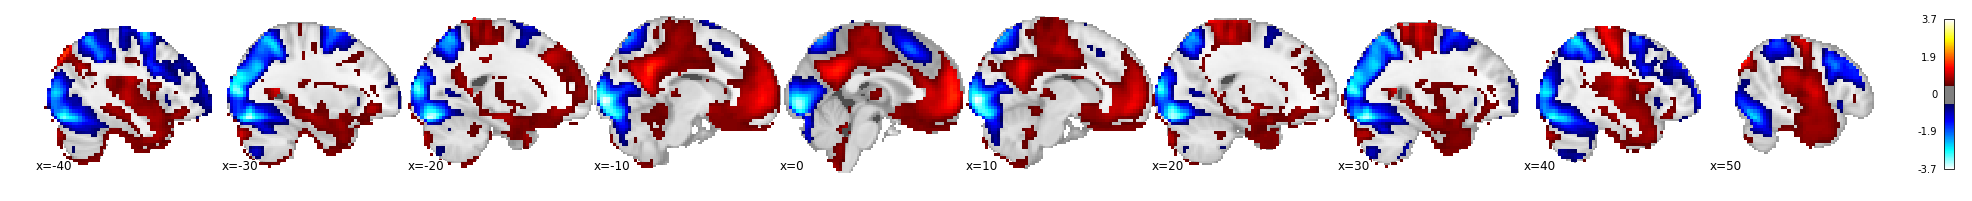

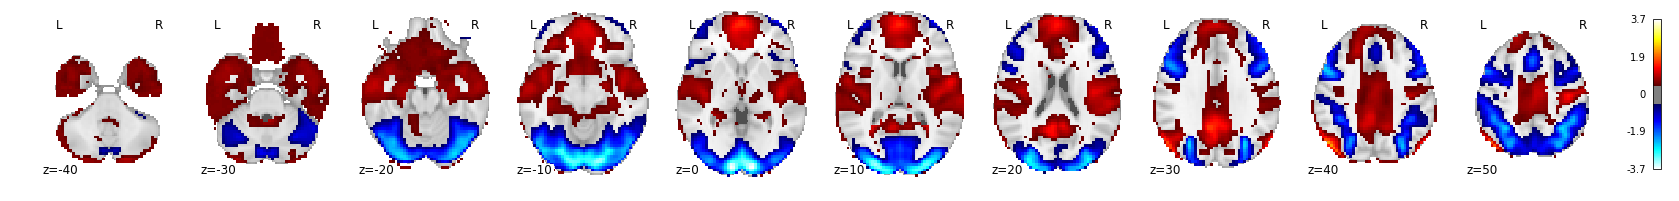

In [103]:
# plot clustered maps
for clust_num in np.unique(part):
    vol = octvec2mat(sbt_clusters['Cluster_{}'.format(clust_num)].get_values(),mask)
    sbt_img = nib.Nifti1Image(vol, affine=m_img.affine, header=m_img.header
    display = plotting.plot_stat_map(sbt_img,cut_coords=(14,6, 0),threshold= 'auto',
                                         title= "cluster_%s" % str(clust_num))
    display = plotting.plot_stat_map(sbt_img, threshold= 'auto',
                                     display_mode='y',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='x',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='z',
                                     cut_coords= range(-40, 60, 10)
                                    )

In [8]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [9]:
# push it to octave
%octave_push y
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

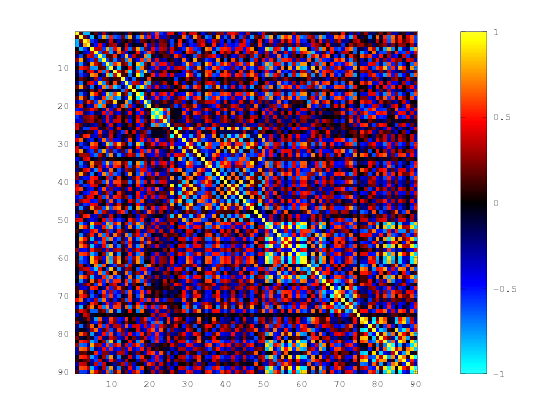

In [10]:
%%octave
nb_cluster =7;   # numb of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 100 Done ! 

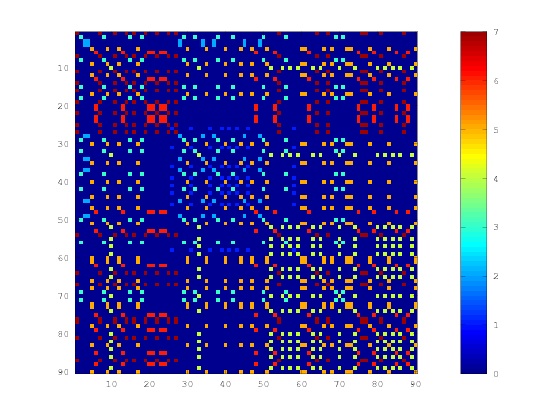

In [11]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

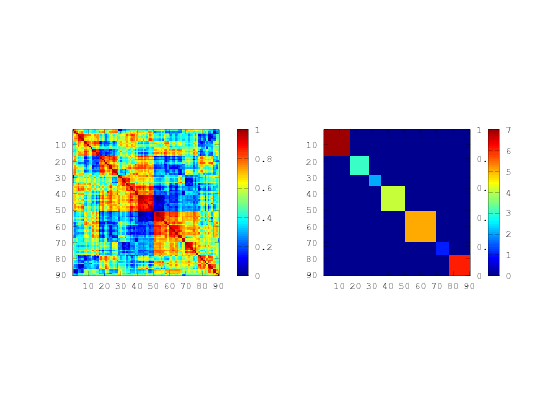

In [12]:
%%octave
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

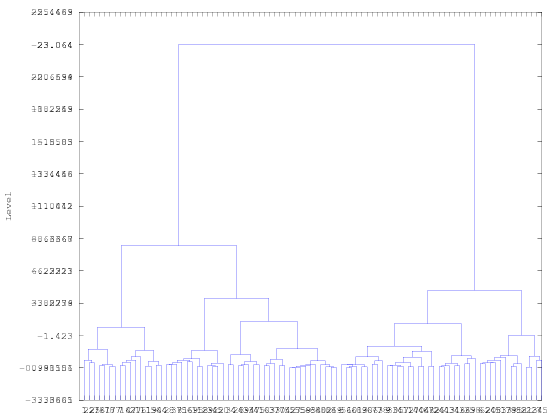

In [13]:
%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [14]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

In [31]:
%%octave -i path_root
save( [path_root filesep 'stability_maps_' date '.mat'],'stab')

Let's have a look at the stability matrix:

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 100 Done ! 

ans =  3

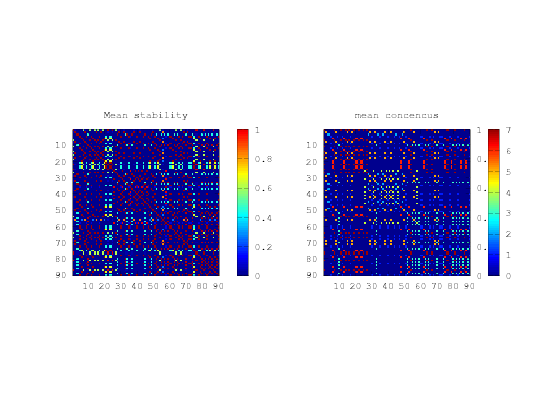

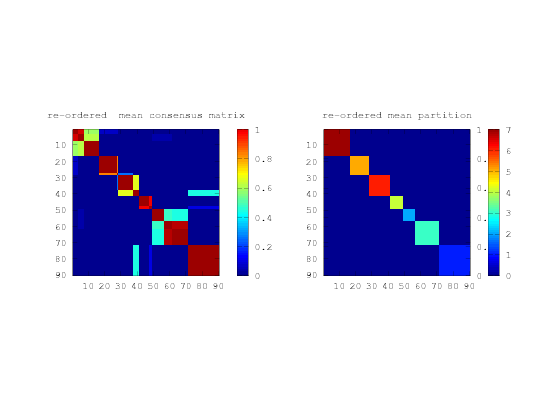

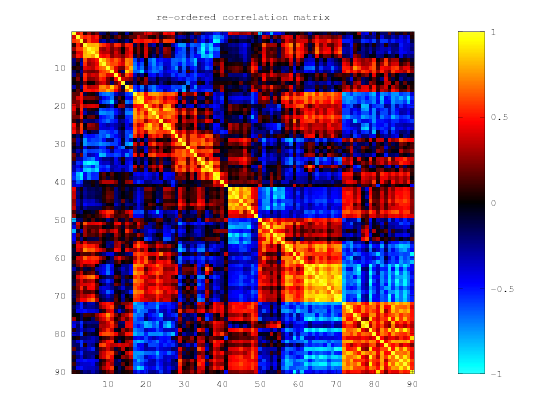

In [17]:
%%octave
subplot(1,2,1)
imagesc(stab), axis square, colormap(jet), colorbar, title('Mean stability')
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
subplot(1,2,2)
niak_visu_part(part_consensus), axis square, colormap(jet),title('mean concencus') # visualize the consensus partition
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
figure
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square,colorbar, title('re-ordered  mean consensus matrix')
# Show the re-ordered partition
subplot(1,2,2)
niak_visu_part(part_consensus(order_consensus)), axis square,colorbar,title('re-ordered mean partition')
# Re-order the correlation matrix
figure
subplot(1,1,1)
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar,title('re-ordered correlation matrix')

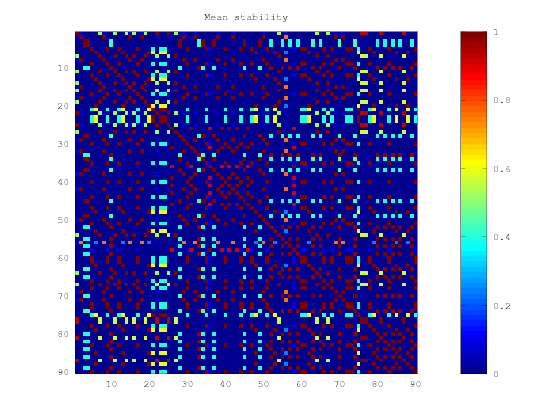

In [19]:
%octave imagesc(stab), axis square, colormap(jet), colorbar, title('Mean stability')

In [20]:
%%octave -o nb_cluster
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 100 Done ! 

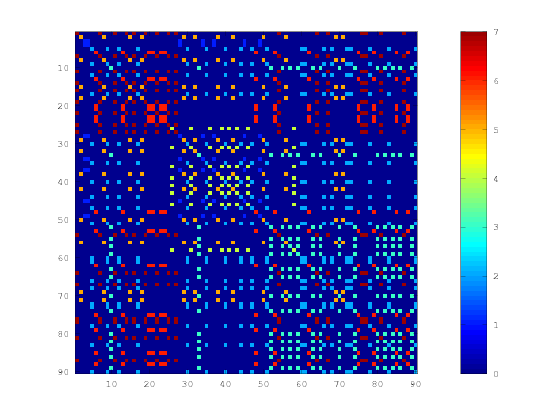

In [21]:
%octave niak_visu_part(part_consensus), axis square, colormap(jet) # visualize the consensus partition

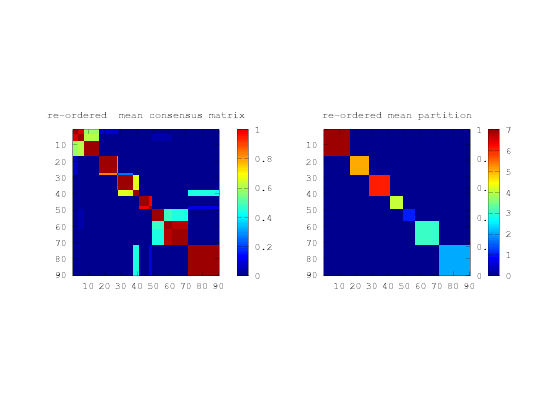

In [22]:
%%octave
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar, title('re-ordered  mean consensus matrix')
subplot(1,2,2)
# Show the re-ordered partition
niak_visu_part(part_consensus(order_consensus)), axis square,title('re-ordered mean partition')

In [23]:
#%octave niak_visu_dendrogram(hier_consensus)

ans =  1

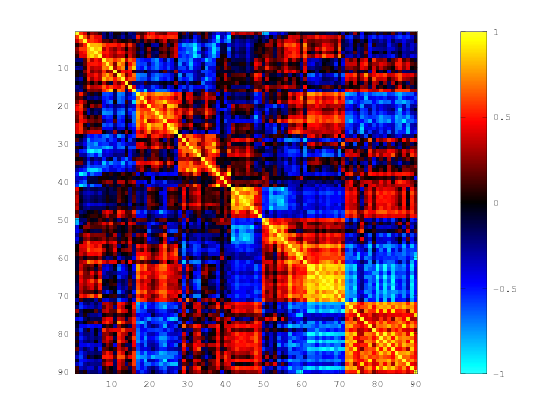

In [24]:
%%octave
# Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar


In [25]:
%%octave -o stack
# calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end

Cluster 1: 

     EMO_contrast_fear_vs_neut_sub3 

     EMO_contrast_fear_vs_neut_sub4 

     MOT_rh_sub4 

     MOT_lh_sub4 

     MOT_lf_sub5 

     MOT_rf_sub3 

     MOT_t_sub2 

Cluster 2: 

     EMO_contrast_fear_vs_neut_sub5 

     GAM_contrast_win_vs_loss_sub4 

     WM_0bk_sub3 

     SOC_contrast_mental_vs_rnd_sub2 

     MOT_lf_sub4 

     SOC_mental_sub1 

     GAM_loss_sub2 

     WM_contrast_2bk_vs_0bk_sub3 

     REL_relation_sub5 

     MOT_lh_sub5 

     REL_match_sub1 

     MOT_rf_sub5 

     WM_2bk_sub5 

     MOT_rh_sub2 

     SOC_contrast_mental_vs_rnd_sub3 

     GAM_win_sub2 

     MOT_t_sub5 

     REL_contrast_relation_vs_match_sub1 

     SOC_mental_sub3 

Cluster 3: 

     GAM_contrast_win_vs_loss_sub5 

     MOT_lh_sub3 

     SOC_contrast_mental_vs_rnd_sub4 

     SOC_mental_sub5 

     REL_contrast_relation_vs_match_sub3 

     REL_match_sub2 

     REL_match_sub5 

     WM_contrast_2bk_vs_0bk_sub5 

     REL_relation_sub2 

     WM_2bk_sub1 

     REL_relation_sub4 

     WM_2bk_sub4 

     REL_contrast_relation_vs_match_sub5 

     WM_0bk_sub2 

     WM_0bk_sub4 

Cluster 4: 

     MOT_rf_sub1 

     MOT_t_sub4 

     MOT_lh_sub1 

     MOT_lf_sub1 

     MOT_lf_sub3 

     MOT_rh_sub1 

     MOT_t_sub1 

     REL_relation_sub3 

Cluster 5: 

     EMO_contrast_fear_vs_neut_sub2 

     SOC_mental_sub4 

     GAM_loss_sub5 

     MOT_lf_sub2 

     SOC_contrast_mental_vs_rnd_sub1 

     GAM_contrast_win_vs_loss_sub3 

     MOT_t_sub3 

     GAM_win_sub3 

     MOT_lh_sub2 

     MOT_rf_sub4 

     MOT_rh_sub5 

     REL_relation_sub1 

Cluster 6: 

     GAM_contrast_win_vs_loss_sub1 

     WM_2bk_sub3 

     REL_contrast_relation_vs_match_sub2 

     WM_contrast_2bk_vs_0bk_sub4 

     REL_match_sub3 

     GAM_loss_sub3 

     GAM_win_sub5 

     MOT_rh_sub3 

     WM_0bk_sub5 

     LAN_story_sub1 

     SOC_contrast_mental_vs_rnd_sub5 

     LAN_story_sub4 

     LAN_story_sub3 

Cluster 7: 

     EMO_contrast_fear_vs_neut_sub1 

     LAN_story_sub2 

     LAN_story_sub5 

     WM_contrast_2bk_vs_0bk_sub1 

     WM_contrast_2bk_vs_0bk_sub2 

     WM_0bk_sub1 

     WM_2bk_sub2 

     GAM_contrast_win_vs_loss_sub2 

     REL_contrast_relation_vs_match_sub4 

     GAM_win_sub4 

     MOT_rf_sub2 

     REL_match_sub4 

     GAM_loss_sub4 

     GAM_win_sub1 

     SOC_mental_sub2 

     GAM_loss_sub1 

In [26]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0
print('NVoxels = {}'.format(np.sum(mask)))
print('Shape = {}'.format(mask.shape))

NVoxels = 59900
Shape = (53, 64, 52)


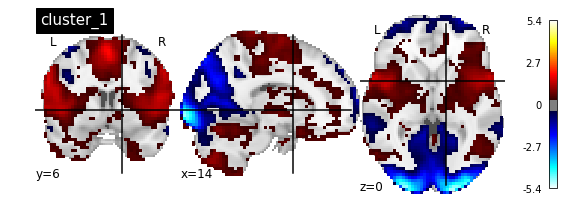

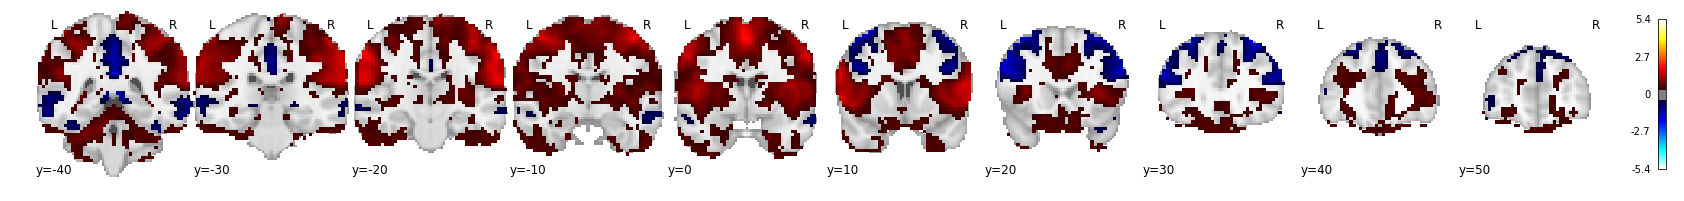

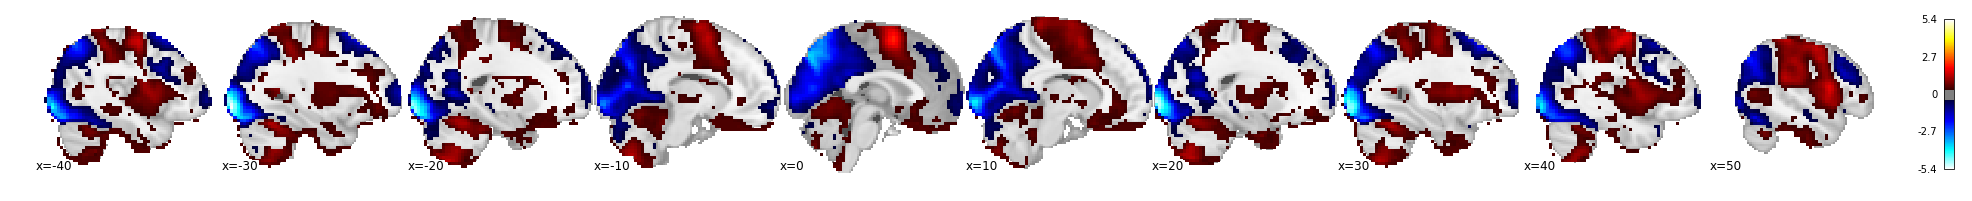

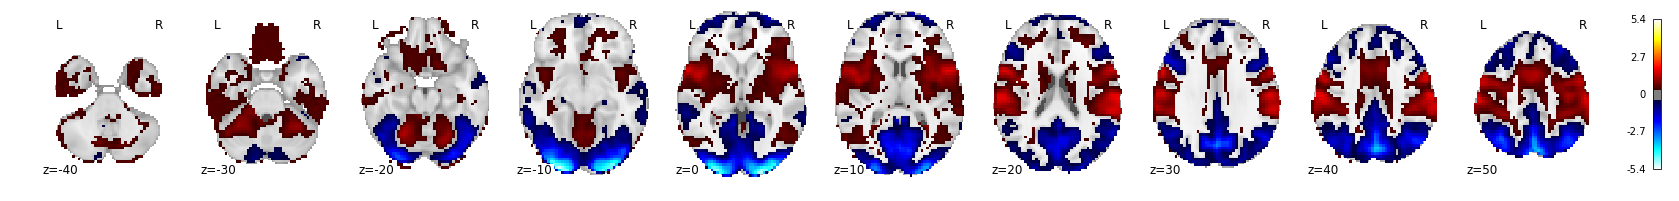

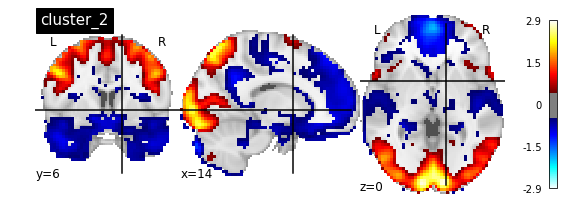

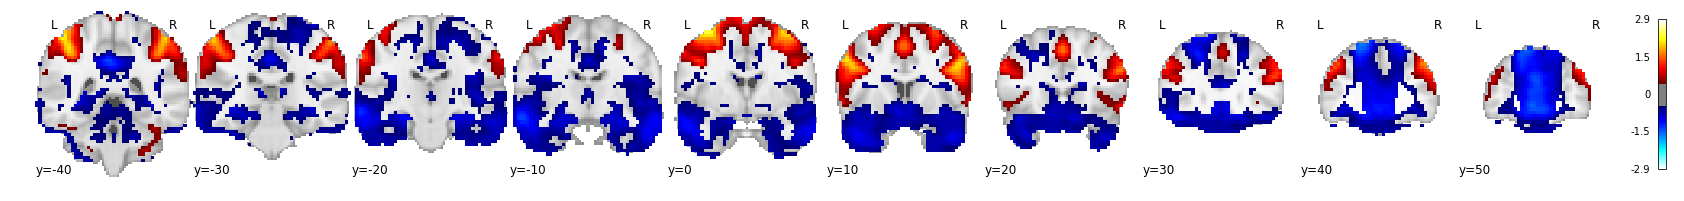

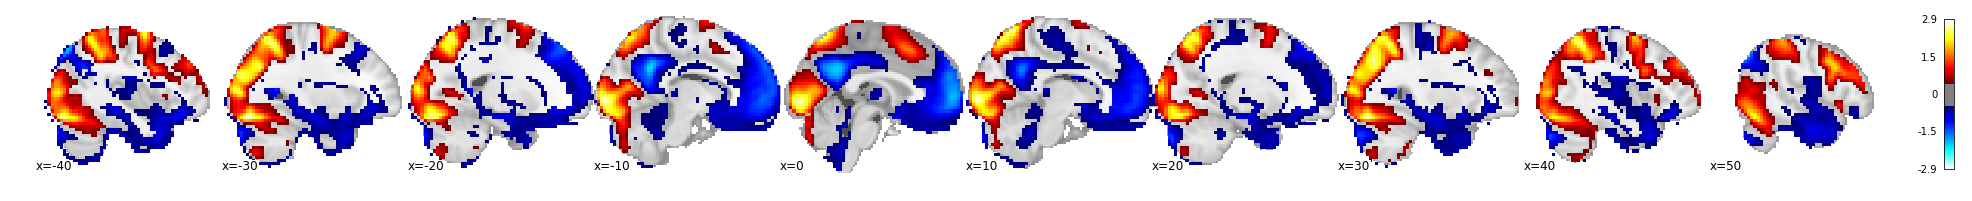

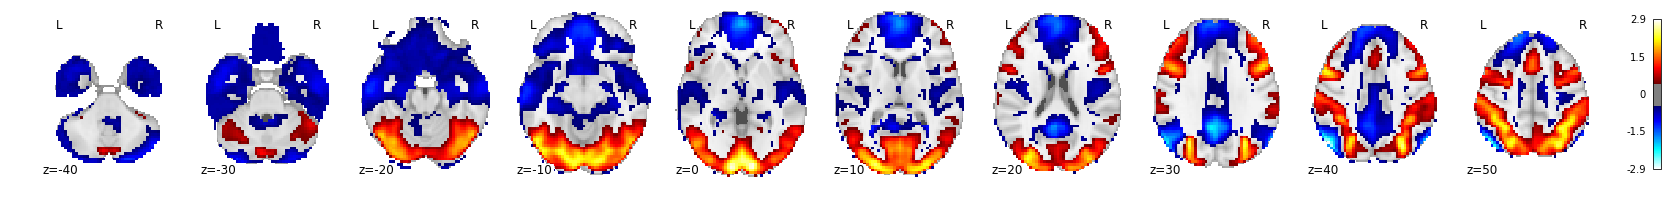

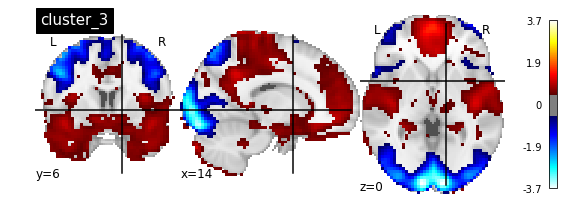

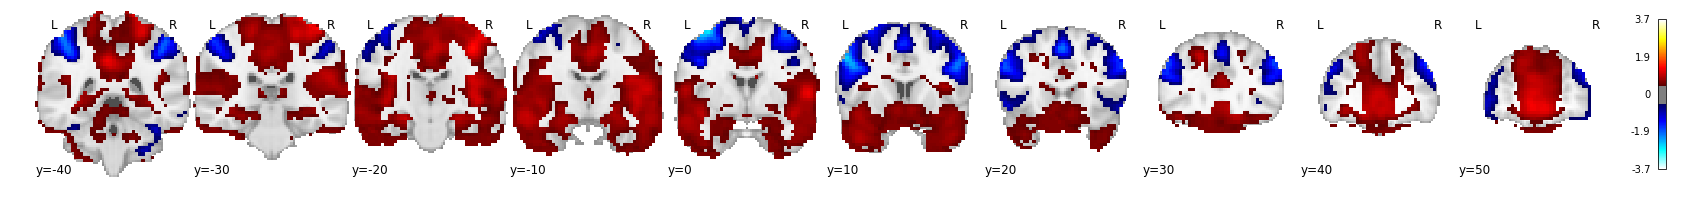

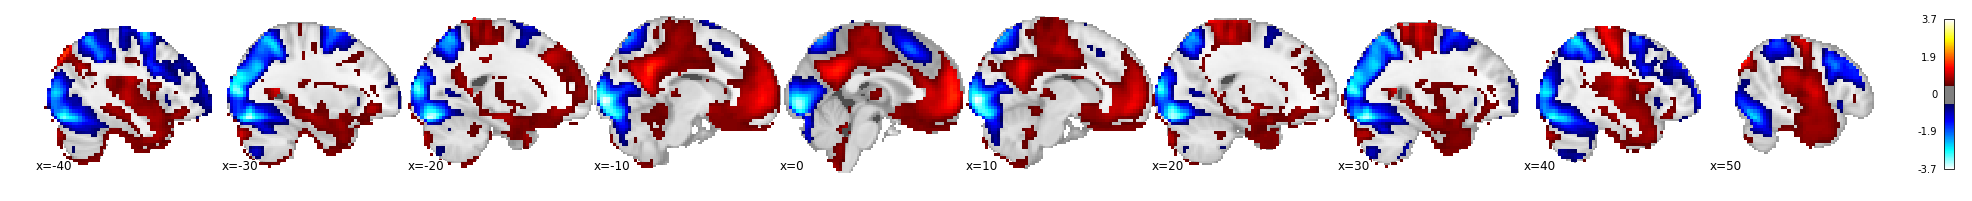

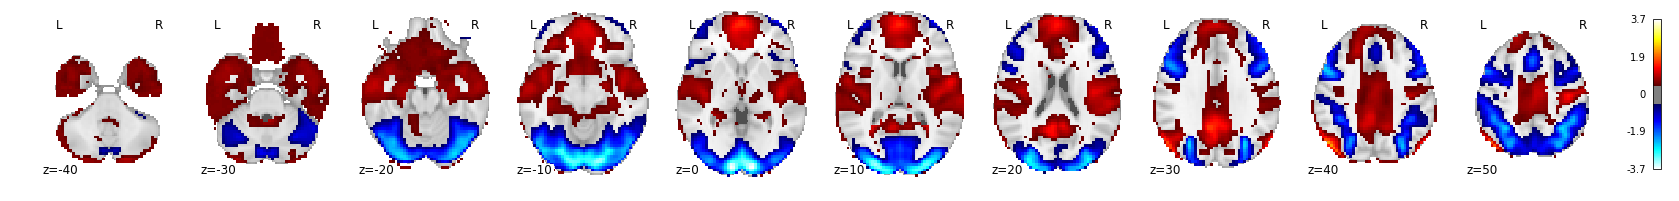

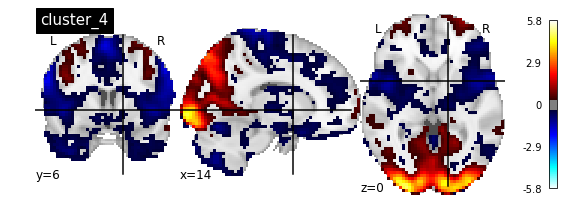

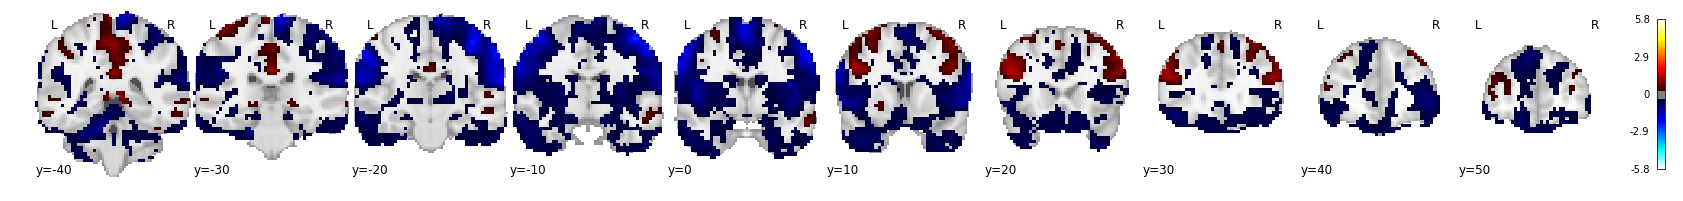

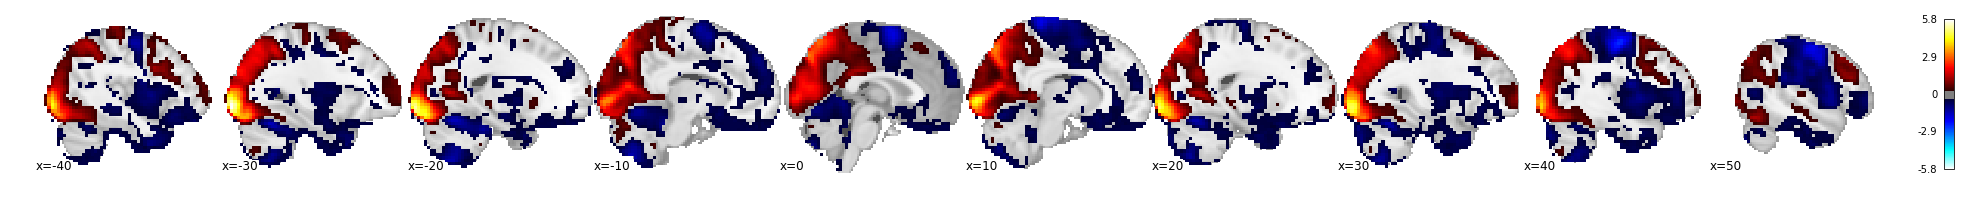

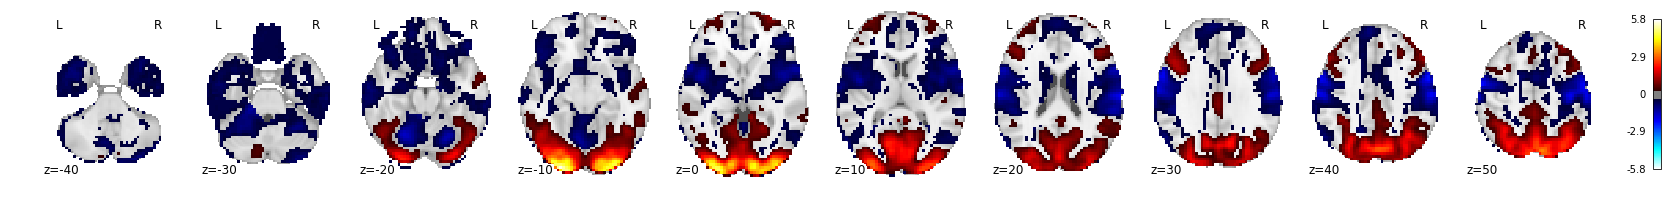

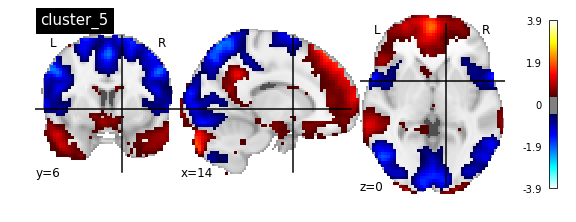

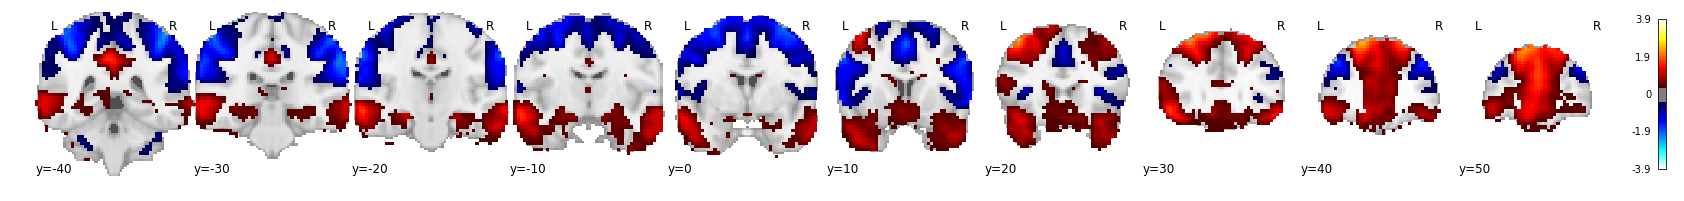

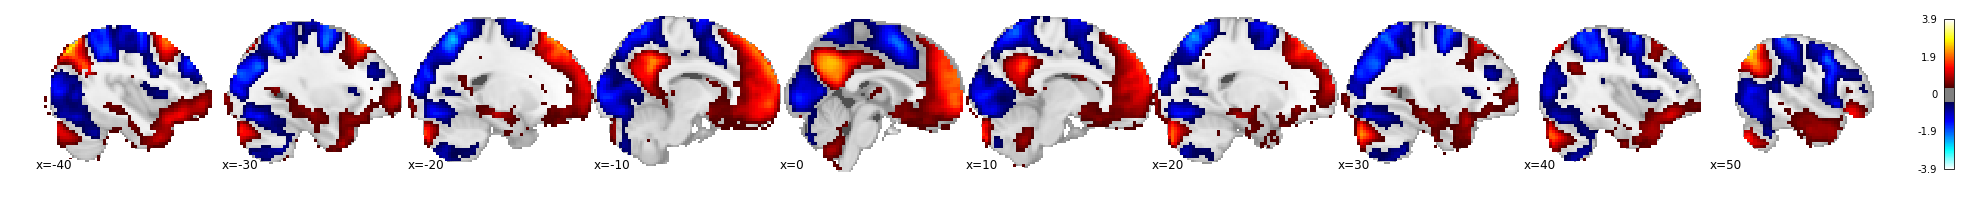

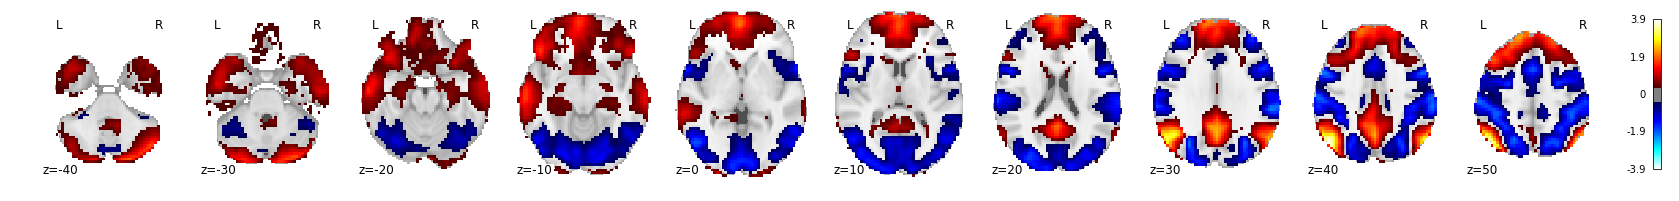

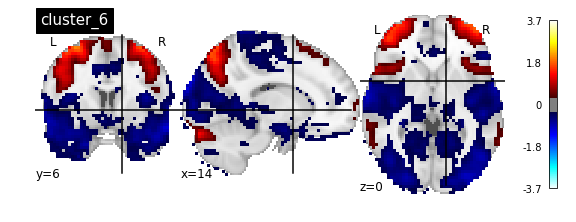

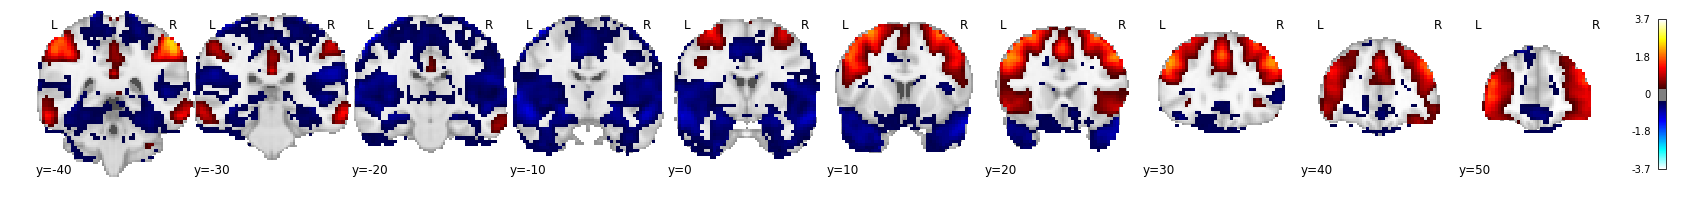

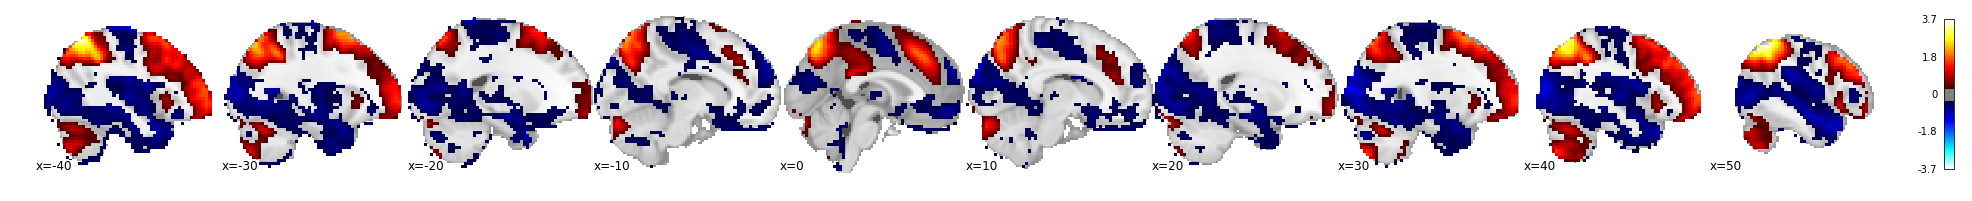

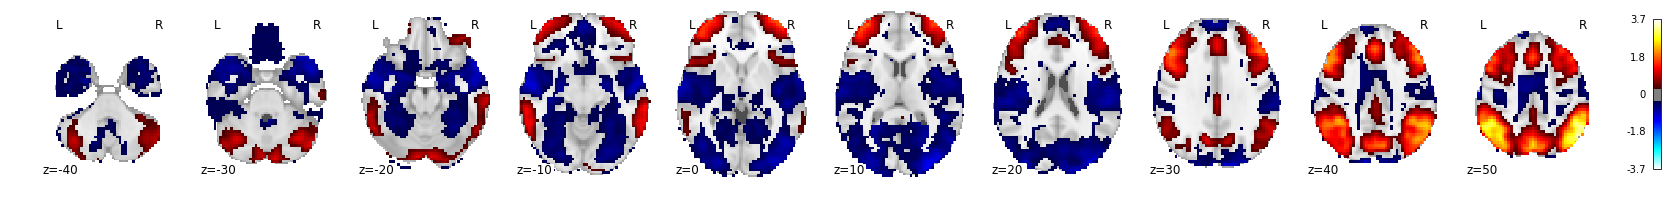

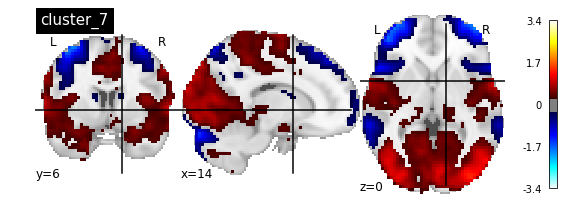

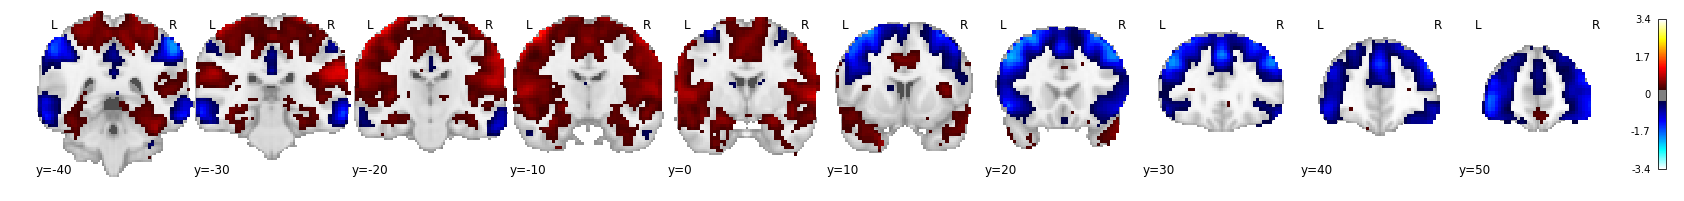

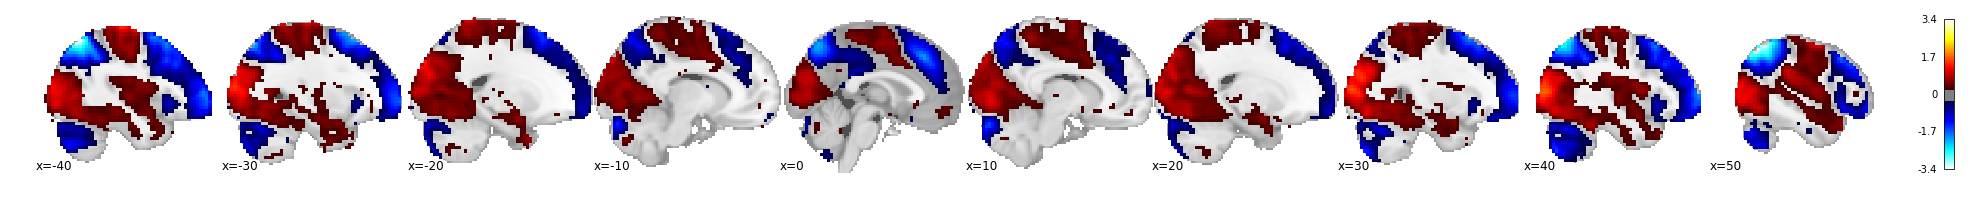

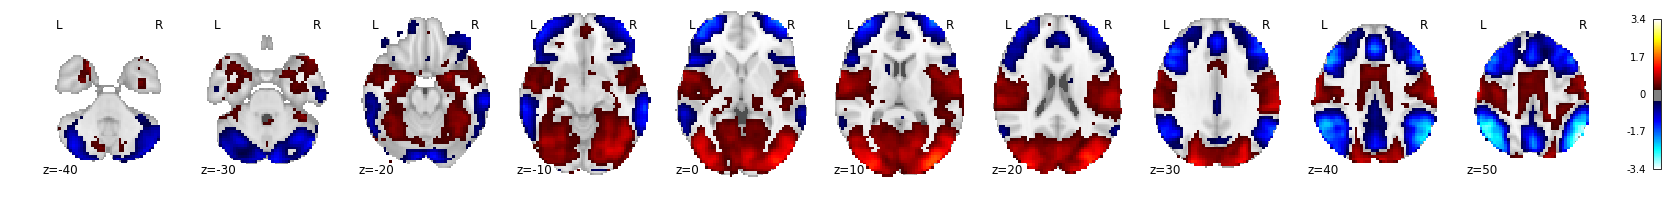

In [27]:
for cluster_num in range(int(nb_cluster)):
    sbt = stack[:,cluster_num]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    %octave_push mask sbt
    %octave vol = niak_tseries2vol(sbt,mask);
    %octave_pull vol
    sbt_img = nib.Nifti1Image(vol, affine=m_img.get_affine(), header=m_img.get_header())
    display = plotting.plot_stat_map(sbt_img,cut_coords=(14,6, 0),threshold= 'auto',
                                     title= "cluster_%s" % str(cluster_num+1))
    display = plotting.plot_stat_map(sbt_img, threshold= 'auto',
                                     display_mode='y',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='x',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='z',
                                     cut_coords= range(-40, 60, 10)
                                    )


ans =  1

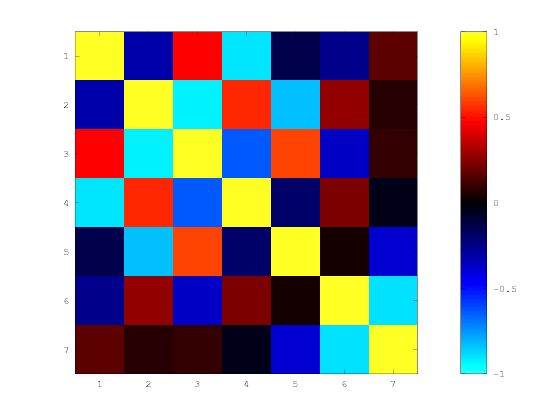

In [28]:
%%octave
Rc = corr(stack);
title('Spatial correlation matrix of clustered pheno')
niak_visu_matrix(Rc), axis square

In [35]:
%octave Rc

Rc =

   1.00000  -0.72730   0.72585  -0.68491   0.51075  -0.76960   0.53675

  -0.72730   1.00000  -0.93900   0.47451  -0.68151   0.54263  -0.19087

   0.72585  -0.93900   1.00000  -0.63232   0.46534  -0.38906   0.27679

  -0.68491   0.47451  -0.63232   1.00000   0.14231   0.10573  -0.84009

   0.51075  -0.68151   0.46534   0.14231   1.00000  -0.79651  -0.28678

  -0.76960   0.54263  -0.38906   0.10573  -0.79651   1.00000  -0.13067

   0.53675  -0.19087   0.27679  -0.84009  -0.28678  -0.13067   1.00000